## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

import cv2

from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from PIL import Image
from torchvision import transforms
from torch.autograd import Variable

SEED = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

torch.cuda.empty_cache() 

## Load Data

In [2]:
DATA_PATH = 'TrafficLightDataset/'
os.listdir(DATA_PATH)

['Annotations',
 'daySequence1',
 'daySequence2',
 'dayTrain',
 'nightSequence1',
 'nightSequence2',
 'nightTrain',
 'sample-dayClip6',
 'sample-nightClip1']

In [3]:
DAY_TRAIN_PATH = 'TrafficLightDataset/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = 'TrafficLightDataset/Annotations/Annotations/nightTrain/'

In [4]:
train_day = []

for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0
    
train_night = []
for clipName in tqdm(sorted(os.listdir(NIGHT_TRAIN_PATH))):
    if 'nightClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(NIGHT_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_night.append(df)

train_night_df = pd.concat(train_night,axis=0)
train_night_df['isNight'] = 1

df = pd.concat([train_day_df,train_night_df],axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 102.31it/s]


In [5]:
df.head()


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


In [6]:
df.tail()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
3231,nightTraining/nightClip5--01450.jpg,go,937,221,976,290,nightTraining/nightClip5/clip5.mp4,1450,nightTraining/nightClip5/clip5.mp4,1450,1
3232,nightTraining/nightClip5--01451.jpg,go,467,36,512,117,nightTraining/nightClip5/clip5.mp4,1451,nightTraining/nightClip5/clip5.mp4,1451,1
3233,nightTraining/nightClip5--01451.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1451,nightTraining/nightClip5/clip5.mp4,1451,1
3234,nightTraining/nightClip5--01452.jpg,go,460,33,506,114,nightTraining/nightClip5/clip5.mp4,1452,nightTraining/nightClip5/clip5.mp4,1452,1
3235,nightTraining/nightClip5--01452.jpg,go,937,219,976,288,nightTraining/nightClip5/clip5.mp4,1452,nightTraining/nightClip5/clip5.mp4,1452,1


## Data Preprocessing

In [7]:
np.all(df['Origin file'] == df['Origin track']), np.all(df['Origin frame number'] == df['Origin track frame number'])

(True, True)

In [8]:
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)


In [9]:
def changeFilename(x):
    filename = x.Filename
    isNight = x.isNight
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    if isNight:
        return os.path.join(DATA_PATH,f'nightTrain/{clipName}/frames/{splitted[-1]}')
    else:
        return os.path.join(DATA_PATH,f'dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [10]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [11]:
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2], dtype=int64)

In [12]:
idx_to_label

{1: 'go', 2: 'warning', 3: 'stop'}

In [13]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
0,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,333,710,358,0,0
1,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,846,391,858,411,0,0
2,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,337,710,357,1,0
3,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,847,390,859,410,1,0
4,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,331,710,356,2,0


In [14]:
df.tail()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
3231,TrafficLightDataset/nightTrain/nightClip5/fram...,1,937,221,976,290,1450,1
3232,TrafficLightDataset/nightTrain/nightClip5/fram...,1,467,36,512,117,1451,1
3233,TrafficLightDataset/nightTrain/nightClip5/fram...,1,937,219,976,288,1451,1
3234,TrafficLightDataset/nightTrain/nightClip5/fram...,1,460,33,506,114,1452,1
3235,TrafficLightDataset/nightTrain/nightClip5/fram...,1,937,219,976,288,1452,1


In [15]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame','isNight']

In [16]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight
0,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,333,710,358,0,0
1,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,846,391,858,411,0,0
2,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,337,710,357,1,0
3,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,847,390,859,410,1,0
4,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,331,710,356,2,0


## Data Analysis

In [17]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  18013 / 51826


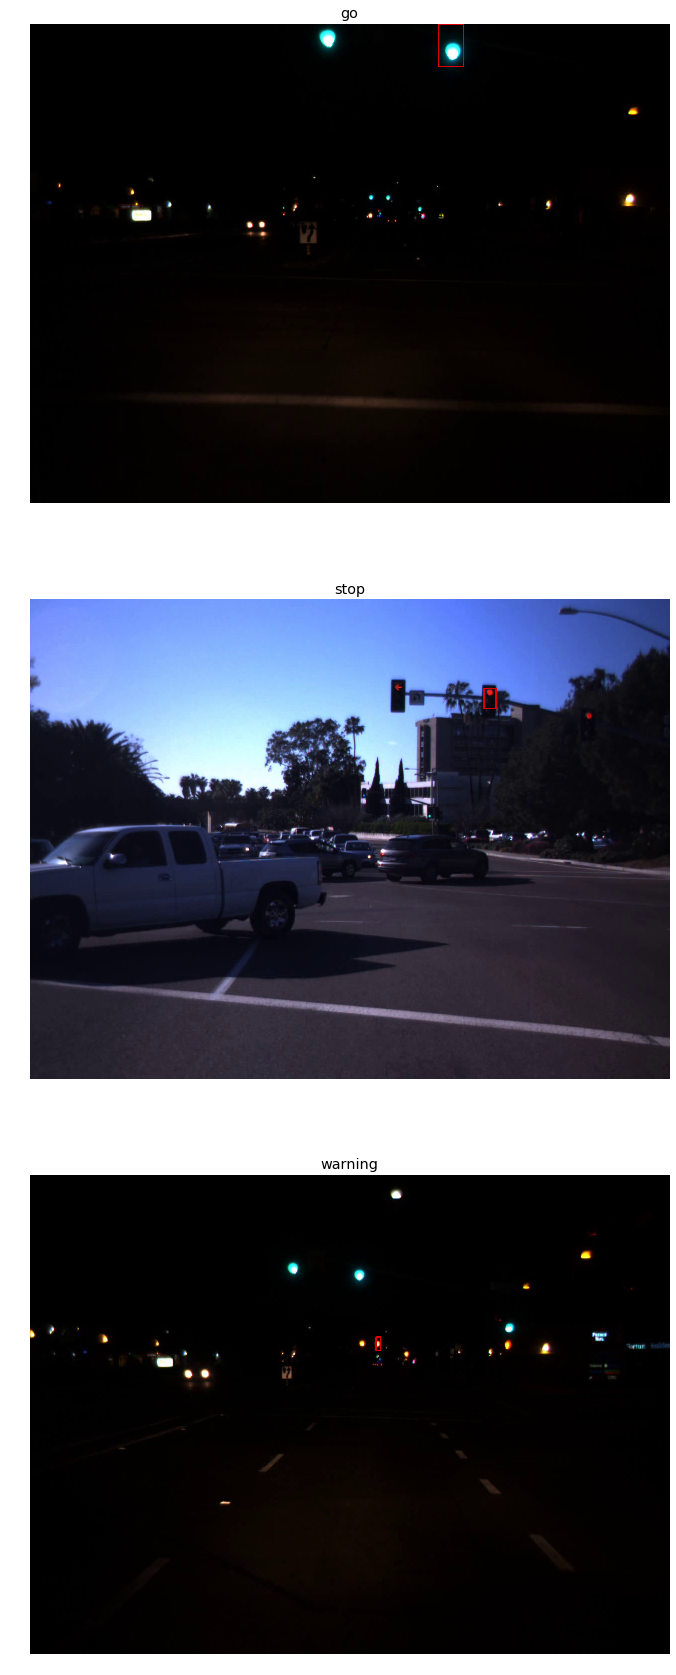

In [18]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

## Train Test Split

In [19]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[2])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9', 'nightClip1', 'nightClip2',
       'nightClip3', 'nightClip4', 'nightClip5'], dtype=object)

In [20]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    testNightClipNames = list(np.random.choice(nightClips,int(len(nightClips)*p)))
    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testNightClipNames + testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [21]:
train_df, test_df = split(df)

In [22]:
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,333,710,358,0,0,dayClip1
1,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,846,391,858,411,0,0,dayClip1
2,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,337,710,357,1,0,dayClip1
3,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,847,390,859,410,1,0,dayClip1
4,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,331,710,356,2,0,dayClip1


In [23]:
test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,TrafficLightDataset/dayTrain/dayClip12/frames/...,1,271,379,283,399,0,0,dayClip12
1,TrafficLightDataset/dayTrain/dayClip12/frames/...,1,610,294,625,314,0,0,dayClip12
2,TrafficLightDataset/dayTrain/dayClip12/frames/...,1,774,359,792,394,0,0,dayClip12
3,TrafficLightDataset/dayTrain/dayClip12/frames/...,1,266,364,284,404,1,0,dayClip12
4,TrafficLightDataset/dayTrain/dayClip12/frames/...,1,609,293,627,313,1,0,dayClip12


In [24]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (47084, 9)
Test shape:  (4742, 9)


In [25]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,333,710,358,0,0,dayClip1
1,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,846,391,858,411,0,0,dayClip1
2,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,337,710,357,1,0,dayClip1
3,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,847,390,859,410,1,0,dayClip1
4,TrafficLightDataset/dayTrain/dayClip1/frames/d...,1,698,331,710,356,2,0,dayClip1


In [26]:
val_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,TrafficLightDataset/dayTrain/dayClip10/frames/...,1,323,288,335,308,0,0,dayClip10
1,TrafficLightDataset/dayTrain/dayClip10/frames/...,1,506,376,518,396,0,0,dayClip10
2,TrafficLightDataset/dayTrain/dayClip10/frames/...,1,587,369,599,389,0,0,dayClip10
3,TrafficLightDataset/dayTrain/dayClip10/frames/...,3,210,261,222,279,0,0,dayClip10
4,TrafficLightDataset/dayTrain/dayClip10/frames/...,1,330,286,342,306,1,0,dayClip10


In [27]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (37128, 9)
Validation shape:  (9956, 9)


## Configuration


In [28]:
EPOCHS = 10
BATCH_SIZE = 8

## Device

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Custom Dataset

In [30]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target, image_id

## Average Loss

In [31]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [32]:
def collate_fn(batch):
    return tuple(zip(*batch))

## Albumentations

In [33]:
def getTrainTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getValTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getTestTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Data Loaders


In [34]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())


In [35]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [36]:
images, targets, image_ids = next(iter(trainDataLoader))

boxes = targets[0]['boxes'].numpy().astype(np.int32)
image = images[0].permute(1,2,0).numpy()

In [37]:
targets[0]

{'boxes': tensor([[167.6000, 192.5333, 174.2000, 208.0000],
         [197.4000, 186.6667, 202.8000, 198.6667],
         [231.6000, 166.6667, 237.0000, 177.3333]]),
 'labels': tensor([3, 3, 3]),
 'image_id': tensor([1132]),
 'area': tensor([1914., 1215., 1080.]),
 'iscrowd': tensor([0, 0, 0])}

In [38]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


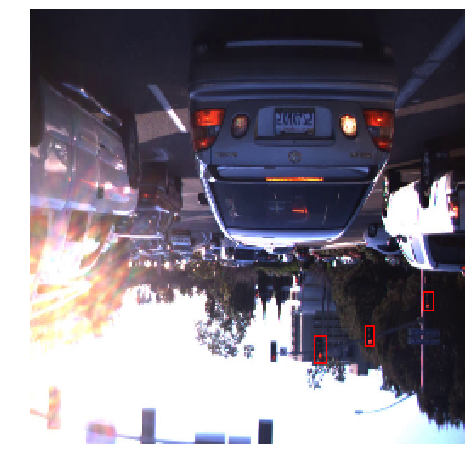

In [39]:
displayImage(image,boxes)

In [40]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 4 

INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

In [41]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
lossHist = LossAverager()
valLossHist = LossAverager()

for epoch in range(EPOCHS):
    
    start_time = time()
    model.train()
    lossHist.reset()
    
    for images, targets, image_ids in tqdm(trainDataLoader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        lossHist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
    
    if lr_scheduler is not None:
        lr_scheduler.step(totalLoss)

    print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [42]:
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

In [43]:
model.eval()
images, targets, image_ids = next(iter(valDataLoader))
images = torch.stack(images).to(device)

outputs = model(images)

In [44]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):
    
    boxes = output['boxes']
    #print("boxes", boxes)
    scores = output['scores']
    #print("scores", scores)
    labels = output['labels']
    #print("labels", labels)
    
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [45]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(256,256))
    image /= 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}
    
    for box,label in zip(boxes,labels):
        print(box)
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 1)
    
    #print("box_0: {}, box_1: {}, box_2: {}, box_3: {}".format(box[0], box[1], box[2], box[3]))

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[116  95 120 104]
[101 103 103 108]


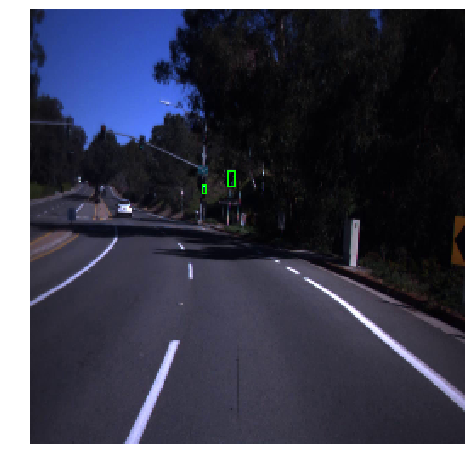

In [46]:
displayPredictions(image_ids[0],outputs[0],0.3,0.5)

In [52]:
model.eval()

preprocess = transforms.Compose([
    transforms.ToTensor()
])

cap = cv2.VideoCapture("project.avi")

while(True):
    ret, input = cap.read()
    image = input.copy()
    input = preprocess(input).float()
    input = input.unsqueeze_(0)
    input = input.type(torch.cuda.FloatTensor)

    result = model(input)

    boxes = result[0]['boxes'].type(torch.cuda.FloatTensor)
    scores = result[0]['scores'].type(torch.cuda.FloatTensor)
    labels = result[0]['labels'].type(torch.cuda.FloatTensor)

    mask = nms(boxes,scores,0.3)
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()

    mask = scores >= 0.5
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}

    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (0,0,255), 1)

    cv2.imshow("image", image)
    
    if cv2.waitKey(0):
        break
    

TypeError: an integer is required (got type str)